# Multi-Label Text Classification

Please check this [article](https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c?sk=8a30075009552cfd4a7534663edaed7e) for a detailed explanation.

In [0]:
import os
import re
import time
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [0]:
begin = time.time()

#### Disabling MLFlow autologging

In [0]:
import mlflow
mlflow.autolog(disable=True)

#### Reading Data Files (directly from zip files)

In [0]:
with ZipFile(os.path.join("data", "topics", 'train.csv.zip'), 'r') as myzip:
    with myzip.open('train.csv') as myfile:
        train_df = pd.read_csv(myfile)
        
with ZipFile(os.path.join("data", "topics", 'test.csv.zip'), 'r') as myzip:
    with myzip.open('test.csv') as myfile:
        test_df = pd.read_csv(myfile)

In [0]:
train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


#### Checking Missing Values and Data Types

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


In [0]:
x = train_df.iloc[:,3:].sum()
rowsums = train_df.iloc[:,2:].sum(numeric_only=True, axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum == 0:
        no_label_count += 1

print("Total number of articles = ",len(train_df))
print("Total number of articles without label = ",no_label_count)
print("Total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
Total labels =  26267


In [0]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum().sum())

print("Check for missing values in Test dataset")
print(test_df.isnull().sum())

Check for missing values in Train dataset
0
Check for missing values in Test dataset
ID          0
TITLE       0
ABSTRACT    0
dtype: int64


#### Checking how many abstracts belongs to each category.

In [0]:
train_df.iloc[:,3:].apply(lambda x:x.sum(), axis=0).values

Out[47]: array([8594, 6013, 5618, 5206,  587,  249])

Out[48]: <AxesSubplot:>

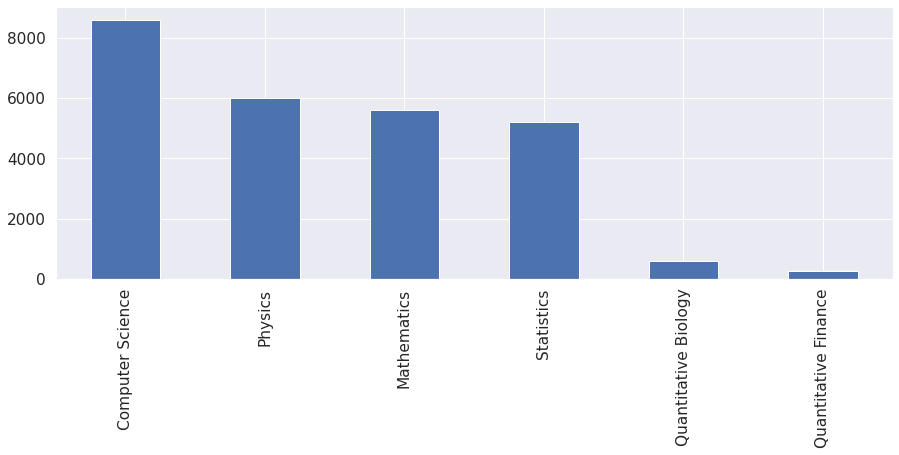

In [0]:
train_df.iloc[:,3:].apply(lambda x:x.sum(), axis=0).plot(kind="bar", figsize=(15,5))

From the above plot its clear that "Quantitative biology" and "Quantitative Finance" have too few values compared to the other categories. This means that the data set is imbalanced.  
To make it balanced we can apply **resampling techniques**. The data set is small so we can try oversampling for these two classes.  

We will implement oversampling later. First we will try to build a basic classification model.

#### Checking the number of words in each category

In [0]:
total_word_count_in_each_category = []
for i in train_df.iloc[:,3:].columns:
    abstracts = train_df.where(train_df[i] == 1)[['ABSTRACT']]
    count = pd.Series(abstracts.values.flatten()).str.len().sum()
    total_word_count_in_each_category.append(count)

Out[50]: <BarContainer object of 6 artists>

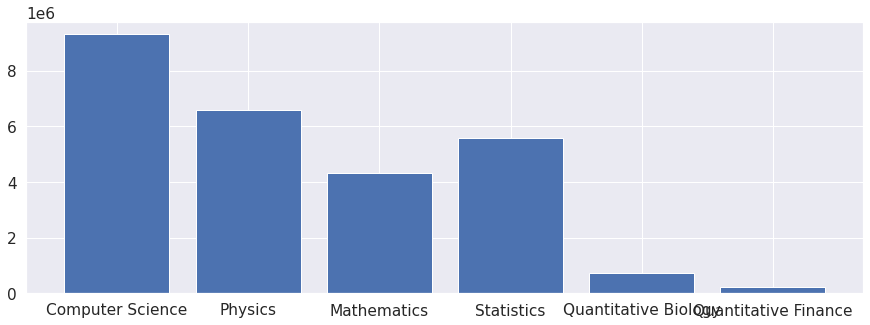

In [0]:
plt.figure(figsize=(15,5))
plt.bar(train_df.iloc[:,3:].columns,total_word_count_in_each_category)

The word count is almost in the same proportion as the number of texts in each category.  
The only difference is statistics which has more words than mathematics even if the number of articles is more for mathematics.  
Now let's calculate the average number of words per category:

In [0]:
avg_abstract_len_for_each_category = []
for i in range(6):
    avg_abstract_len_for_each_category.append(total_word_count_in_each_category[i]/train_df.iloc[:,3:].apply(lambda x:x.sum(), axis=0).values[i])

Out[52]: <BarContainer object of 6 artists>

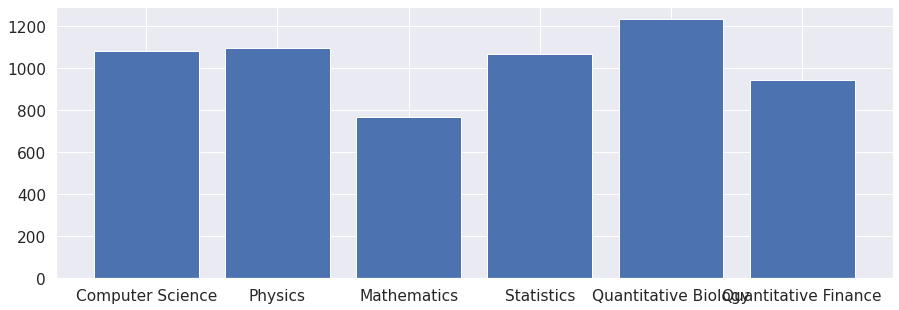

In [0]:
plt.figure(figsize=(15,5))
plt.bar(train_df.iloc[:,3:].columns, avg_abstract_len_for_each_category)

From the above plot its clear that articles of quantitative biology are the longest, and mathematics articles are the shortest.

#### Preparing the Corpus  
Let's concatenate 'Title' and 'Abstract' and make it one big text.

In [0]:
train_df["text"] = train_df["TITLE"] + " " + train_df["ABSTRACT"]

We drop the 'Title' and 'Abstract' columns as they are not needed anymore.

In [0]:
train_df.drop(["TITLE","ABSTRACT"],axis=1,inplace=True)

In [0]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


Let's make a function for train/test split as we will need this further.

In [0]:
def split(X,y,test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return (X_train, X_test, y_train, y_test)

#### Cleaning the text

In [0]:
def clean_text(input_text):
    x = re.sub('[^\w]|_', ' ', input_text)  # only keep numbers and letters and spaces
    x = x.lower()
    x = re.sub(r'[^\x00-\x7f]',r'', x)  # remove non ascii texts
    x = [y for y in x.split(' ') if y] # remove empty words
    x = ['[number]' if y.isdigit() else y for y in x]
    cleaned_text =  ' '.join(x)
    return cleaned_text

In [0]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [0]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstructing subject specific effect maps pr...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation in...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonics and poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,a finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study of discrete wavelet transfor...


In [0]:
train_df.cleaned_text[0]

Out[60]: 'reconstructing subject specific effect maps predictive models allow subject specific inference when analyzing disease related alterations in neuroimaging data given a subject s data inference can be made at two levels global i e identifiying condition presence for the subject and local i e detecting condition effect on each individual measurement extracted from the subject s data while global inference is widely used local inference which can be used to form subject specific effect maps is rarely used because existing models often yield noisy detections composed of dispersed isolated islands in this article we propose a reconstruction method named rsm to improve subject specific detections of predictive modeling approaches and in particular binary classifiers rsm specifically aims to reduce noise due to sampling error associated with using a finite sample of examples to train classifiers the proposed method is a wrapper type algorithm that can be used with different binary cl

#### Splitting our dataset using the previously defined function

In [0]:
X_train, X_test, y_train, y_test = split(train_df.loc[:,"cleaned_text"], train_df.iloc[:,1:7], 0.2)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Out[62]: ((16777,), (4195,), (16777, 6), (4195, 6))

Now that our text is cleaned we will apply Tfidf on the text data to convert it into a matrix of numericals.

#### Changing text into numericals using Tfidf technique

In [0]:
tfidf = TfidfVectorizer(min_df=5, 
                        max_features=1000, 
                        strip_accents="unicode", 
                        analyzer="word",
                        token_pattern=r"\w{1,}",
                        ngram_range=(1,2),
                        use_idf=True,
                        smooth_idf=True,
                        sublinear_tf=True,
                        stop_words="english")

#### Fitting in the train data, transforming train and test data

In [0]:
tfidf.fit(list(X_train) + list(X_test))

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [0]:
X_train_tfidf.shape

Out[65]: (16777, 1000)

#### The target column is made up of 6 columns , so lets change it to one columns with all 6 different categories.

In [0]:
y_train_new = y_train.idxmax(axis=1)
y_test_new = y_test.idxmax(axis=1)

In [0]:
y_train_new.nunique(), y_test_new.nunique()

Out[67]: (6, 6)

#### Let's apply a simple Logistic Regression model to classify.   
Apply a grid search to optimize the hyperparameters.

In [0]:
params={
    'C':[0.8,1, 1.3],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty':['l1', 'l2', 'elasticnet', 'none']
}

gs_lr = GridSearchCV(LogisticRegression(),
                     param_grid=params,
                     scoring='accuracy',
                     cv=3, n_jobs=-1)

gs_model = gs_lr.fit(X_train_tfidf, y_train_new)

/databricks/python/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.7903677         nan 0.78762578 0.79489786
 0.79483825 0.79543433 0.79489786 0.79495746        nan        nan
        nan        nan        nan 0.72009334 0.74971733        nan
 0.73147806 0.73803476        nan        nan 0.79275211        nan
 0.78899675 0.79454019 0.79448058 0.79644758 0.79454019 0.79459977
        nan        nan        nan        nan        nan 0.72009334
 0.74971733        nan 0.73094162 0.73803476        nan        nan
 0.7923945         nan 0.78941403 0.7944209  0.79430172 0.79591111
 0.7944209  0.79465933        nan        nan        nan        nan
        nan 0.72009334 0.74971733        nan 0.73159725 0.73827318]
  warnings.warn(


In [0]:
gs_model.best_params_

Out[69]: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

#### Creating a LR classifier with the best parameters found

In [0]:
clf = LogisticRegression(C=gs_model.best_params_['C'],
                         solver=gs_model.best_params_['solver'],
                         penalty=gs_model.best_params_['penalty'],
                         n_jobs=-1)

clf.fit(X_train_tfidf, y_train_new)
clf.score(X_test_tfidf, y_test_new)

/databricks/python/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
Out[70]: 0.7899880810488678

In [0]:
train_preds = clf.predict(X_train_tfidf)
test_preds = clf.predict(X_test_tfidf)
train_preds

Out[71]: array(['Computer Science', 'Mathematics', 'Computer Science', ...,
       'Physics', 'Computer Science', 'Computer Science'], dtype=object)

#### Evaluating the Model

Our data set is imbalanced and all the classes are equally important, so for this case a macro average F1 score would be the best.  
The confusion matrix would then give an overall good picture of every class's prediction.

In [0]:
print ("Test accuracy: {:.5f}".format(accuracy_score(y_test_new,test_preds)))
print()
print(metrics.classification_report(y_test_new,test_preds, digits=4))

Test accuracy: 0.78999

                      precision    recall  f1-score   support

    Computer Science     0.7592    0.8983    0.8230      1692
         Mathematics     0.7784    0.8018    0.7899       898
             Physics     0.8780    0.8850    0.8814      1130
Quantitative Biology     0.7857    0.1196    0.2075        92
Quantitative Finance     0.8889    0.2000    0.3265        40
          Statistics     0.5189    0.1603    0.2450       343

            accuracy                         0.7900      4195
           macro avg     0.7682    0.5108    0.5456      4195
        weighted avg     0.7775    0.7900    0.7661      4195



In [0]:
print('train f1 score', f1_score(y_train_new, clf.predict(X_train_tfidf), average='macro'))
print('test f1 score', f1_score(y_test_new, clf.predict(X_test_tfidf), average='macro'))
print("train accuracy",accuracy_score(y_train_new,clf.predict(X_train_tfidf)))
print("test accuracy",accuracy_score(y_test_new,clf.predict(X_test_tfidf)))

train f1 score 0.5935629677785911
test f1 score 0.5455625181925098
train accuracy 0.8238660070334386
test accuracy 0.7899880810488678


We got 79.93 accuracy using logistic regression and the macro average F1 score is 0.4557.

Out[74]: Text(79.49999999999999, 0.5, 'Actual')

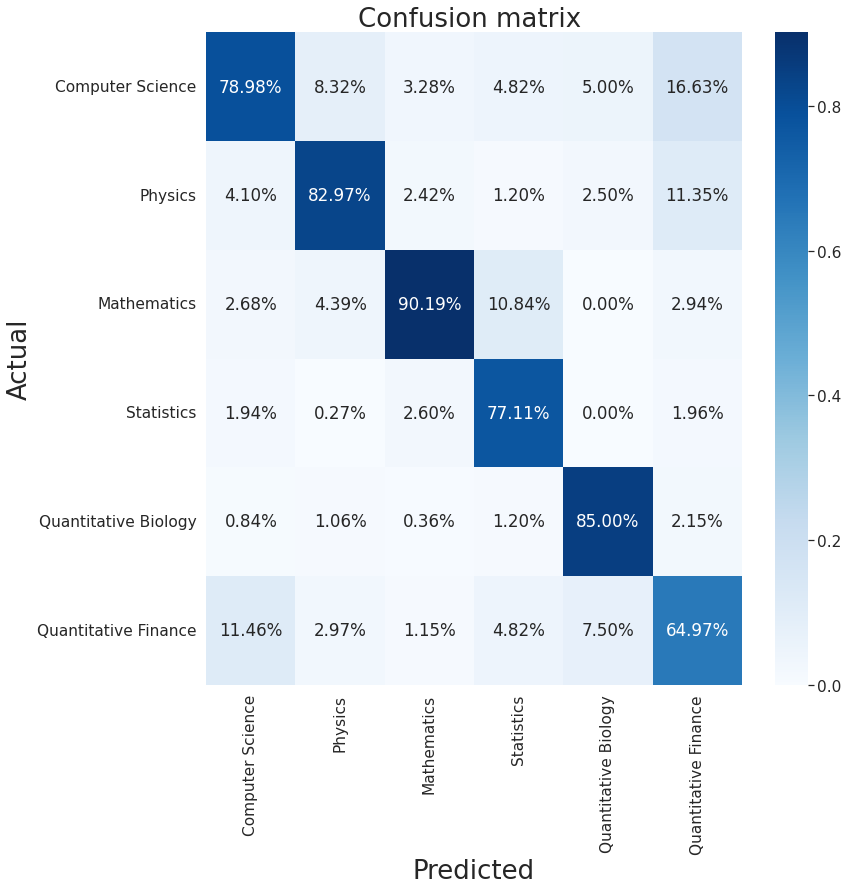

In [0]:
c_matrix = confusion_matrix(y_train_new,
                            clf.predict(X_train_tfidf))

c_matrix = pd.DataFrame(c_matrix,
                        columns=train_df.iloc[:,1:7].columns,
                        index=train_df.iloc[:,1:7].columns)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix), fmt="0.2%", annot=True, cmap="Blues", ax=ax)
ax.set_title("Confusion matrix ", fontsize=26)
ax.set_xlabel("Predicted", fontsize=26)
ax.set_ylabel("Actual", fontsize=26)

Out[75]: Text(79.49999999999999, 0.5, 'Actual')

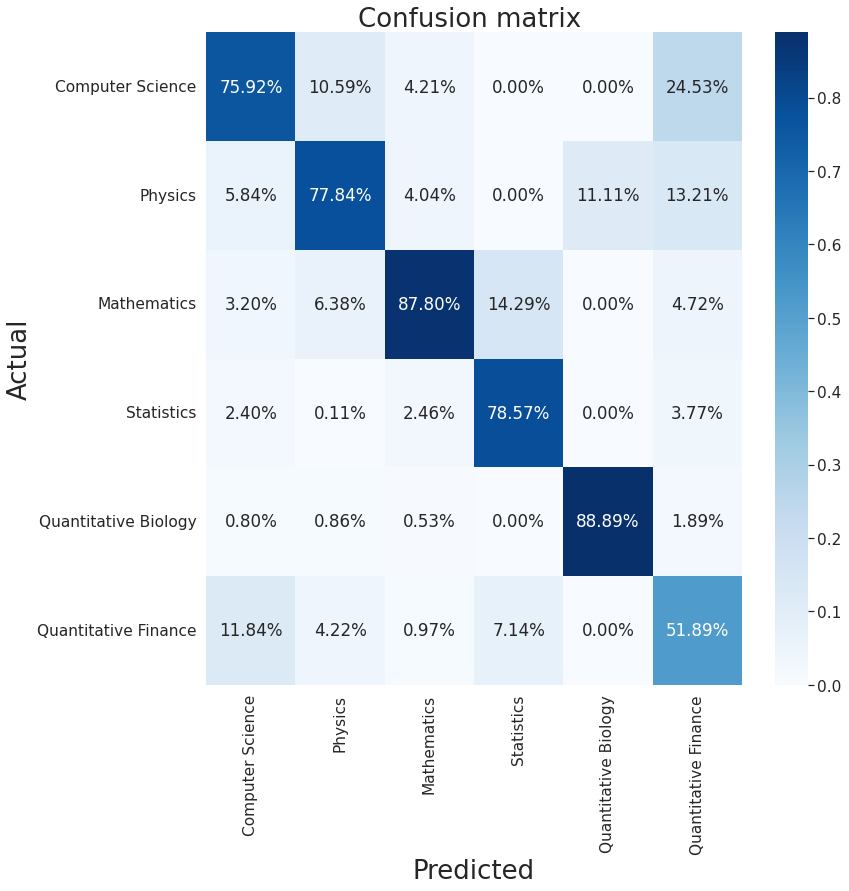

In [0]:
c_matrix = confusion_matrix(y_test_new,clf.predict(X_test_tfidf))

c_matrix = pd.DataFrame(c_matrix,
                        columns=train_df.iloc[:,1:7].columns,
                        index=train_df.iloc[:,1:7].columns)

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix), fmt="0.2%", annot=True, cmap="Blues", ax=ax)
ax.set_title("Confusion matrix ", fontsize=26)
ax.set_xlabel("Predicted", fontsize=26)
ax.set_ylabel("Actual", fontsize=26)

# References

* https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/  
* https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff  
* https://www.thepythoncode.com/article/text-classification-using-tensorflow-2-and-keras-in-python   
* https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles/code

In [0]:
print(f"Execution took: {((time.time() - begin)/60)} minutes")

Execution took: 18.417309963703154 minutes
